<figure style="float:right">
    <img
    src="./data/callat_logo.png"
    width="150"
    alt="CalLat logo"
    /img>
</figure>

# Jupyter notebook for CalLat gA project 

## Import libraries

In [1]:
import pandas as pd
pd.options.display.max_rows = 16
import numpy as np
import scipy as sp
%matplotlib inline
import matplotlib as mpl
import lsqfit
import gvar as gv
import callat_ga_lib as xlib
import sys
print("python version:", sys.version)
print("pandas version:", pd.__version__)
print("numpy  version:", np.__version__)
print("scipy  version:", sp.__version__)
print("mpl    version:", mpl.__version__)
print("lsqfit version:", lsqfit.__version__)
print("gvar   version:", gv.__version__)

python version: 3.6.1 |Anaconda 4.4.0 (x86_64)| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
pandas version: 0.20.1
numpy  version: 1.12.1
scipy  version: 0.19.0
mpl    version: 2.0.2
lsqfit version: 9.1.3
gvar   version: 8.3.2


## Define analysis parameters
* `switches['ensembles']` | list of strings
    * select the ensembles that are used to perform the extrapolation
    * the three rows correspond to the 0.15, 0.12, and 0.09 fm ensembles that are available
* `switches['ansatz']` | dictionary
    * define the fit ansatz for the extrapolation
    * `['type']` | string: chooses between a Taylor expansion or Baryon Xpt
        * Taylor expansion only includes even powers of ε<sub>π</sub>
    * `['truncation']` | integer: is an integer n corresponding to the order of ε<sub>π</sub><sup>n</sup>
    * `['FV']` | boolean: True turns on NLO FV corrections for both Baryon Xpt and Taylor
    * `['xsb']` | boolean: True turns on am<sub>π</sub> term for Baryon Xpt
    * `['alpha']` | boolean: True turns on α<sub>s</sub>a<sup>2</sup> for Baryon Xpt

In [2]:
switches = dict()
# Ensembles used in extrapolation
switches['ensembles'] = ['l1648f211b580m0217m065m838','l1648f211b580m0166m065m838','l1648f211b580m013m065m838','l2448f211b580m0064m0640m828','l3248f211b580m00235m0647m831',
                'l2464f211b600m0170m0509m635','l2464f211b600m0130m0509m635','l2464f211b600m0102m0509m635','l2464f211b600m00507m0507m628','l3264f211b600m00507m0507m628','l4064f211b600m00507m0507m628','l4864f211b600m00184m0507m628',
                'l3264f211b630m0124m037m440','l3264f211b630m00945m037m440','l3296f211b630m0074m037m440','l4896f211b630m00363m0363m430']

switches['ansatz'] = dict()
switches['ansatz']['type'] = 'taylor' # Type of fit: 'xpt', 'taylor', 'linear', 'constant'
switches['ansatz']['truncation'] = 2 # Order to truncate series
switches['ansatz']['FV'] = True # True turns on NLO FV correction
switches['ansatz']['xsb'] = False # True turns on O(a) discretization
switches['ansatz']['alpha'] = False # True turns on O(alpha_s a^2) discretization

## Define priors and PDG values
`gvar` datatype has the form `gv.gvar(mean, standard deviation)`

[gvar documentation](https://github.com/gplepage/gvar/blob/master/doc/gvar.pdf)

In [3]:
priors = dict()
# Xpt priors
priors['xpt'] = dict()
priors['xpt']['g0'] = gv.gvar(1.0, 1.0) # LO LEC
priors['xpt']['a1'] = gv.gvar(0.0, 1E-3) # DWF order a discretization
priors['xpt']['c2'] = gv.gvar(0.0, 50.0) # NLO counterterm epi^2
priors['xpt']['c3'] = gv.gvar(0.0, 50.0) # NNLO LEC epi^3
priors['xpt']['a2'] = gv.gvar(0.0, 50.0) # NLO a^2
priors['xpt']['s2'] = gv.gvar(0.0, 1.0) # NLO alpha_s a^2
priors['xpt']['a4'] = gv.gvar(0.0, 1.0) # NNNLO a^4
priors['xpt']['b4'] = gv.gvar(0.0, 1.0) # NNNLO a^2 epi^2
priors['xpt']['c4'] = gv.gvar(0.0, 10.0) # NNNLO epi^4
# taylor priors
priors['taylor'] = dict()
priors['taylor']['g0'] = gv.gvar(1.5, 1.5) # FV coefficient
priors['taylor']['c0'] = gv.gvar(1.0, 10.0) # constant
priors['taylor']['c2'] = gv.gvar(0.0, 10.0) # epi^2
priors['taylor']['a2'] = gv.gvar(0.0, 10.0) # a^2
priors['taylor']['c4'] = gv.gvar(0.0, 10.0) # epi^4
priors['taylor']['a4'] = gv.gvar(0.0, 1.0) # a^4
priors['taylor']['b4'] = gv.gvar(0.0, 1.0) # a^2 epi^2
# linear priors
priors['linear'] = dict()
priors['linear']['g0'] = gv.gvar(1.5, 1.5) # FV coefficient
priors['linear']['c0'] = gv.gvar(1.0, 10.0) # constant
priors['linear']['c2'] = gv.gvar(0.0, 10.0) # epi
priors['linear']['a4'] = gv.gvar(0.0, 10.0) # a^2
priors['linear']['c4'] = gv.gvar(0.0, 1.0) # epi^2
# constant priors
priors['constant'] = dict()
priors['constant']['g0'] = gv.gvar(1.5, 1.5) # FV coefficient
priors['constant']['c0'] = gv.gvar(1.0, 10.0) # constant
priors['constant']['a2'] = gv.gvar(0.0, 10.0) # a^2
priors['constant']['a4'] = gv.gvar(0.0, 1.0) # a^4

# Physical parameters from PDG
phys_params = dict()
# http://pdg.lbl.gov/2016/tables/rpp2016-tab-mesons-light.pdf
phys_params['mpi'] = gv.gvar(139.57018, 0.00035) # mpi +/- [MeV]
# http://pdg.lbl.gov/2016/reviews/rpp2016-rev-pseudoscalar-meson-decay-cons.pdf
phys_params['fpi'] = gv.gvar(130.2, 1.7) # fpi + ['MeV']

## Import data
[pandas dataframe documentation](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html)

In [4]:
# import correlator bootstraps
gadf = pd.read_csv('./data/github_ga_v2.csv')
gadf.groupby('ensemble').describe()[['ga','epi']]

ga                                          \
                               count      mean       std       min       25%   
ensemble                                                                       
l1648f211b580m013m065m838     5001.0  1.215922  0.011742  1.180243  1.207896   
l1648f211b580m0166m065m838    5001.0  1.192666  0.014937  1.122217  1.183607   
l1648f211b580m0217m065m838    5001.0  1.214411  0.010059  1.181044  1.207681   
l2448f211b580m0064m0640m828   5001.0  1.234081  0.011274  1.194841  1.226436   
l2464f211b600m00507m0507m628  5001.0  1.271018  0.027648  1.175531  1.252519   
l2464f211b600m0102m0509m635   5001.0  1.212982  0.011816  1.170193  1.204814   
l2464f211b600m0130m0509m635   5001.0  1.221105  0.010185  1.177154  1.214302   
l2464f211b600m0170m0509m635   5001.0  1.218777  0.009390  1.187069  1.212369   
l3248f211b580m00235m0647m831  5001.0  1.262219  0.072413  1.071303  1.213338   
l3264f211b600m00507m0507m628  5001.0  1.258742  0.014600  1.197767  1.248760   
l3264f211b630m00945m037m440   5001.0  1.226672  0.017163  1.162985  1.215087   
l3264f211b630m0124m037m440    5001.0  1.211583  0.015247  1.148231  1.201179   
l3296f211b630m0074m037m440    5001.0  1.256943  0.014634  1.210480  1.246890   
l4064f211b600m00507m0507m628  5001.0  1.251906  0.021038  1.172414  1.238134   
l4864f211b600m00184m0507m628  5001.0  1.289305  0.029890  1.180580  1.268853   
l4896f211b630m00363m0363m430  5001.0  1.252071  0.008538  1.209421  1.246589   

                                                               epi            \
                                   50%       75%       max   count      mean   
ensemble                                                                       
l1648f211b580m013m065m838     1.214899  1.222887  1.281075  5001.0  0.249570   
l1648f211b580m0166m065m838    1.193729  1.203032  1.237107  5001.0  0.274111   
l1648f211b580m0217m065m838    1.214410  1.220944  1.253205  5001.0  0.303739   
l2448f211b580m0064m0640m828   1.233937  1.241649  1.272587  5001.0  0.181232   
l2464f211b600m00507m0507m628  1.270476  1.289662  1.380602  5001.0  0.184187   
l2464f211b600m0102m0509m635   1.212910  1.221008  1.255163  5001.0  0.244851   
l2464f211b600m0130m0509m635   1.221095  1.227897  1.254163  5001.0  0.270633   
l2464f211b600m0170m0509m635   1.218831  1.224958  1.258458  5001.0  0.298413   
l3248f211b580m00235m0647m831  1.254129  1.300221  1.847861  5001.0  0.113400   
l3264f211b600m00507m0507m628  1.258865  1.268513  1.315906  5001.0  0.182205   
l3264f211b630m00945m037m440   1.226742  1.238464  1.298636  5001.0  0.269033   
l3264f211b630m0124m037m440    1.211687  1.221874  1.261476  5001.0  0.298026   
l3296f211b630m0074m037m440    1.256645  1.266344  1.321978  5001.0  0.246186   
l4064f211b600m00507m0507m628  1.251229  1.264230  1.339749  5001.0  0.181555   
l4864f211b600m00184m0507m628  1.288847  1.309447  1.394666  5001.0  0.113472   
l4896f211b630m00363m0363m430  1.251934  1.257544  1.288477  5001.0  0.181974   

                                                                      \
                                   std       min       25%       50%   
ensemble                                                               
l1648f211b580m013m065m838     0.000360  0.248304  0.249325  0.249569   
l1648f211b580m0166m065m838    0.000503  0.272501  0.273768  0.274117   
l1648f211b580m0217m065m838    0.000532  0.301960  0.303377  0.303742   
l2448f211b580m0064m0640m828   0.000361  0.180032  0.180986  0.181232   
l2464f211b600m00507m0507m628  0.000567  0.182176  0.183812  0.184181   
l2464f211b600m0102m0509m635   0.000501  0.243096  0.244509  0.244860   
l2464f211b600m0130m0509m635   0.000688  0.268260  0.270166  0.270630   
l2464f211b600m0170m0509m635   0.000521  0.296671  0.298063  0.298403   
l3248f211b580m00235m0647m831  0.000735  0.108955  0.112971  0.113465   
l3264f211b600m00507m0507m628  0.000423  0.180769  0.181916  0.182197   
l3264f211b630m00945m037m440   0.000634  0.266541  0.2686

In [5]:
# import HISQ parameters
hqdf = pd.read_csv('./data/hisq_params.csv')
hqdf

,ensemble,aw0_mean,aw0_sdev,alfs
0,l1648f211b580m0217m065m838,0.8804,0.0003,0.58801
1,l1648f211b580m0166m065m838,0.8804,0.0003,0.58801
2,l1648f211b580m013m065m838,0.8804,0.0003,0.58801
3,l2448f211b580m0064m0640m828,0.8804,0.0003,0.58801
4,l3248f211b580m00235m0647m831,0.8804,0.0003,0.58801
5,l2464f211b600m0170m0509m635,0.7036,0.0005,0.53796
6,l2464f211b600m0130m0509m635,0.7036,0.0005,0.53796
7,l2464f211b600m0102m0509m635,0.7036,0.0005,0.53796
8,l2464f211b600m00507m0507m628,0.7036,0.0005,0.53796
9,l3264f211b600m00507m0507m628,0.7036,0.0005,0.53796


## Format data for analysis

In [6]:
data = xlib.format_data(switches, gadf, hqdf)

## Chiral-continuum fit
[lsqfit documentation](https://github.com/gplepage/lsqfit/blob/master/doc/lsqfit.pdf)

In [7]:
result = xlib.fit_data(switches, priors, data, phys_params)
print(result['fit'])
print("physical point result:", result['phys']['result'])
print('%s, %s, %s, %s' %(result['phys']['result'].mean, result['phys']['result'].sdev, result['fit'].chi2/result['fit'].dof, result['fit'].logGBF))

Least Square Fit:
  chi2/dof [dof] = 0.66 [16]    Q = 0.83    logGBF = 29.726

Parameters:
          epi 0   0.30375 (54)      [ 0.30374 (54) ]  
              1   0.27414 (52)      [ 0.27412 (52) ]  
              2   0.24956 (36)      [ 0.24957 (36) ]  
              3   0.18123 (36)      [ 0.18123 (36) ]  
              4   0.11346 (75)      [ 0.11346 (75) ]  
              5   0.29839 (52)      [ 0.29840 (52) ]  
              6   0.27064 (69)      [ 0.27063 (69) ]  
              7   0.24489 (51)      [ 0.24486 (51) ]  
              8   0.18420 (57)      [ 0.18418 (58) ]  
              9   0.18219 (44)      [ 0.18220 (44) ]  
             10   0.18155 (42)      [ 0.18155 (42) ]  
             11   0.11351 (52)      [ 0.11351 (52) ]  
             12   0.29802 (81)      [ 0.29801 (81) ]  
             13   0.26903 (65)      [ 0.26903 (65) ]  
             14   0.24616 (44)      [ 0.24619 (44) ]  
             15   0.18197 (37)      [ 0.18197 (37) ]  
          aw0 0   0.88040 (30

## Systematic error budget
The total uncertainty here differs from the paper because uncertainty from finite volume and isospin breaking have yet to be included. These two systematic uncertainties are estimated independently and added in quadrature after this analysis.

In the paper, the input uncertainty is absorbed into the statistical uncertainty.

In [8]:
error = xlib.error_budget(switches,result)
pd.DataFrame.from_dict(error).rename(index={0: 'pct. uncertainty'})[['stat','chiral','disc','input','total']]

,stat,chiral,disc,input,total
pct. uncertainty,0.812353,0.019078,0.011679,0.017597,0.812852


## Plot results
* chiral extrapolation
* convergence of extrapolation
* continuum extrapolation
* infinite volume extrapolation

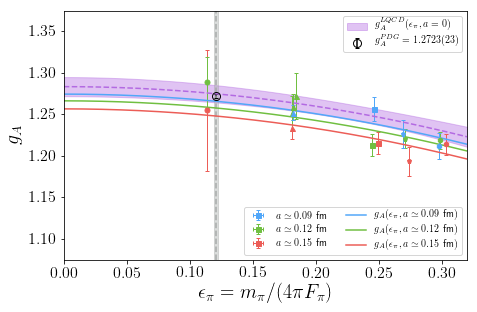

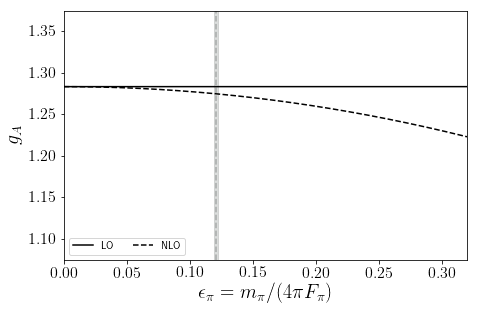

In [9]:
# Chiral extrapolation and series convergence
Plot = xlib.plot_chiral_fit()
Plot.plot_chiral(switches,data,result)
mpl.pyplot.show()

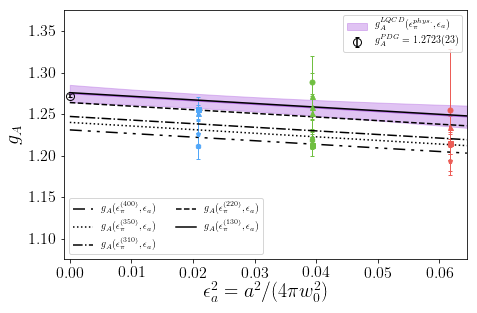

In [10]:
# Continuum extrapolation
Plot = xlib.plot_chiral_fit()
Plot.plot_continuum(switches,data,result)
mpl.pyplot.show()

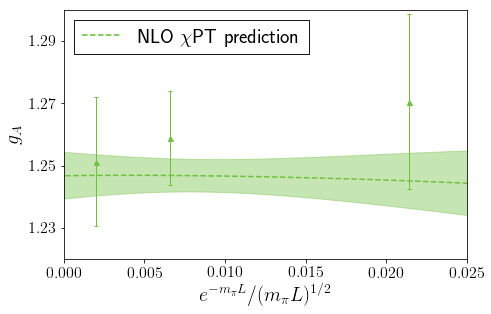

In [11]:
# Infinite volume extrapolation at 220 MeV 0.12 fm
Plot = xlib.plot_chiral_fit()
Plot.plot_volume(switches,data,result)
mpl.pyplot.savefig("chipt_IV.pdf",transparent=True)
mpl.pyplot.show()

<center>
    <span style="color: black; font-family: Helvetica; font-size: 2em">
        These calculations are made possible by
    </span>
</center>

<figure>
    <img src='./data/incite_logo.png' width='200' />
</figure>
<figure>
    <img src='./data/olcf_logo.png' width='240' />
</figure>
<figure>
    <img src='./data/llnl_logo.png' width='550' />
</figure>